# Links

[Open main branch version of this notebook in Colab](https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/main/Classification_NM2022_Sfenj1.ipynb)

[Open development branch version of this notebook in Colab](https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/development/Classification_NM2022_Sfenj1.ipynb)


# General

The job of this notebook is to:

* Load the feature data into a `master_df` DataFrame
* Build a relatively simple multinomial GLM to predict behavioral state given features of interest

## Style / naming guide / coding hints

* Axes in column labels such as 'X' and 'Y' are always capitalized: e.g. `left_ear_X`
* All coordinates are in cm, area in cm^2 etc.
* All angles are in degrees
* 0° is up / north in the video frame




# Housekeeping

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import seaborn as sns

# Loading the data from Google Drive

In [2]:
#Because we are using a Shared with me drive, we need to have a small workaround
#In your shared with me folder, right click on:
#NMA_2022_Sfenj_Group_1"
#And click "Make a shortcut", and have this shortcut within your own drive

#now we can mount our drive
from pickle import load
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
#Since you have mounted your drive, which includes this shortcut, you can now access the files within that shortcut:
feature_df = pd.read_csv('/content/drive/MyDrive/NMA_2022_Sfenj_Group_1/unstable_feature_df.csv',index_col=0)

#test by showing the head
feature_df.head()

Mounted at /content/drive


,Unnamed: 0,Unnamed: 0.1,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,...,head_orientation,spd_head_centroid,spd_body_centroid,spd_centroid,acc_head_centroid,acc_body_centroid,acc_centroid,distance,poly_area_head,poly_area_body
0,0,0,0,0,0,3,22.059926,5.382346,21.370271,6.655555,...,-76.930682,NaN,NaN,NaN,NaN,NaN,NaN,4.244334,0.378178,1.377622
1,1,1,1,0,0,1,22.096829,5.355307,21.460224,6.681567,...,-81.724107,2.470806,6.215506,4.074207,NaN,NaN,NaN,4.257485,0.352497,1.259771
2,2,2,2,0,0,1,22.247188,4.770894,21.663633,6.495032,...,-102.724356,7.378437,3.004966,3.851131,147.228931,-96.316187,-6.692275,4.378617,0.557240,1.263289
3,3,3,3,0,0,1,21.929907,4.645837,21.638130,6.237349,...,-102.994617,6.647651,2.418231,3.412081,-21.923601,-17.602061,-13.171507,4.361401,0.437631,1.380436
4,4,4,4,0,0,1,21.804926,4.627531,21.539674,5.900741,...,-94.236395,7.185160,3.110226,4.968029,16.125266,20.759847,46.678465,4.307015,0.255402,1.513766


In [5]:
#import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

#Remove NaNs. There is one NaN in the area inherently, and then a few nans in speed and acc since they require differencing
feature_df = feature_df.dropna(axis = 0) 

#optional to remove all "other" states, coded as state 3
feature_df_no_other = feature_df[feature_df.annotations != 3]
#feature_df = feature_df_no_other

#Get a list of predictor names. Feel free to experiment
pred_names = ['centroid_X','centroid_Y','poly_area_head','poly_area_body','spd_centroid','acc_centroid','distance','head_vs_body_angle','head_orientation']
#pred_names = ['centroid_X','centroid_Y','poly_area_head','spd_centroid','acc_centroid']

#to dO: 
#mouse id
#moving average/smoothing
#Interaction terms

#Use predictor names to get a dataframe of just predictors
x = feature_df[pred_names]

#optional get data only of res or int
feature_df_res = feature_df[feature_df.mouse_id == 0]
feature_df_int = feature_df[feature_df.mouse_id == 0]
x_res = feature_df_res[pred_names]
x_int = feature_df_int[pred_names]

#Get the annotations (beh states) to predict
y = feature_df['annotations']
y_res = feature_df_res['annotations']
y_int =  feature_df_int['annotations']
# annotations: Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}

#specify model, have it as multinomial to predict beh states (0,1,2,3)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=100)
#Fit the model (predict y from x), given the above terms
model.fit(x,y)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Mean Accuracy: 0.685 (0.004)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


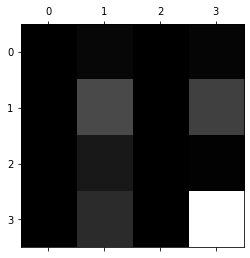

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.12      0.01      0.01     28064
           1       0.49      0.53      0.51    293168
           2       0.00      0.00      0.00     57218
           3       0.78      0.85      0.82    636746

    accuracy                           0.69   1015196
   macro avg       0.35      0.35      0.33   1015196
weighted avg       0.64      0.69      0.66   1015196



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
#Let's dig into the model a little bit more. Import some packages to assess model performance
from statsmodels.tools import add_constant
from sklearn import metrics

#predict y using the model
yhat = model.predict(x)
#Build a confusion matrix, which shows you actual states vs. predicted states
c_matrix = metrics.confusion_matrix(y, yhat)

#show confusion matrix in grayscale
plt.matshow(c_matrix, cmap=plt.cm.gray)
plt.show()

from sklearn.metrics import classification_report
y_actual = pd.Series(y, name='Actual')
y_predicted = pd.Series(yhat, name='Predicted')
#Create classification report
class_report=classification_report(y, y_predicted)
print(class_report)
#Precision = Tru Pos/ Tru Pos + False Pos (chance that it correctly identified a given class, given that it identified it)
#Recall = Tru Pos/Tru Pos + Fals Neg (correct identification of actual class)

In [7]:
#Get coefficients for each term
#Do more research on how to interprett coefs in multinomial model
model_coefs = pd.DataFrame(zip(x.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])
print(model_coefs)

             features      coef
0          centroid_X -0.039809
1          centroid_Y -0.042909
2      poly_area_head -0.002177
3      poly_area_body -0.005756
4        spd_centroid  0.009404
5        acc_centroid -0.000138
6            distance -0.068834
7  head_vs_body_angle -0.003112
8    head_orientation -0.000540
